# Intro to Ophyd & Ophyd-Async

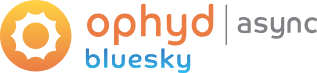

In this tutorial I will try to give you a quick overview of the `ophyd` and `ophyd-async` libraries, explain their purpose in the `bluesky` stack, and show you how to leverage them for integrating disparate hardware components into beamline DAQ.

## What is Ophyd?

Ophyd is an abstraction layer that enables experiment orchestration and data acquisition code to operate above the specifics of particular devices and control systems. In other words ophyd:

**Puts the details specific to a device or control system behind a high-level interface with methods like trigger(), read(), and set(...).**

Another way of thinking of this is that for each device at the beamline, you can probably think of a select few operations that it performs, that you can describe with a verb. For example, 

* Move
* Read
* Trigger
* Locate
...

A motor moves from position A to position B. A temperature controller moves from temperature A to B. While the way the hardware gets told to do this is likely very different, and even the higher level EPICS controls are very different, in a scientific DAQ context we'd prefer it if we could write an experimental routine that could be re-used with both.

Say you have a single axis step scan, where you move a motor to points equidistant to each other, and at each point, you take a reading from a detector. You can write an experimental plan that commands the motor to move to each subsequent point, and asks the detector to trigger and read. Now say your next user wants to use the same detector, but instead of moving a motor, this time the detector remains stationary, and instead your sample stage temperature is ramped by 10 degrees between measurements.

Even though the hardware is very different, from the point of view of a bluesky plan, the above two experiments are equivalent, thanks to the ophyd devices for each physical device abstracting away how a `move` command should be processed by the hardware.

**Groups individual control channels (such as EPICS PVs) into logical "Devices" to be configured and used as units with internal coordination.**

An EPICS IOC provides remote access to a device's functionality over the network. You are probably already familiar with the concept of a Process Variable (PV), which is essentially a named endpoint at which this remote control or monitoring can be performed for a single component of the device. An IOC will typically have many PVs, each of which will control or monitor one feature. For example, on a motor you would have a read-only PV for current position, a read/write PV for commanded position, a read only PV flagging whether the motor is moving or at-rest, etc.

While within the IOC itself there is of course a relationship between all of these PVs, when viewed externally over the network all PVs from all IOCs are accessible together, with only the naming convention for PVs providing any insight into which device each one links to. Thus, the second responsibility of `ophyd` is to provide the interface for grouping all of these independent signals back together at the DAQ code level, so that we can reference our hardware by device, rather than by individual signals.

**Assigns readings with names meaningful for data analysis that will propagate into metadata.**

PV names are often quite long, and not very user friendly. Ophyd allows for re-naming signals to give them more scientifically useful names.

**Categorizes readings by "kind" (primary reading, configuration, engineering/debugging) which can be read selectively.**

During instantiation of a device, you can easily add information to each signal on what it's purpose is, whether it be data, configuration, debugging, etc, so that the DAQ system will immediately know what to do with each one. For example, signals marked as configuration will be read once at the start of a scan and be entered into scan metadata. primary reading signals will be read at each point, and can optionally be used to generate plots or live view tables.

## What is Ophyd-Async?

Ophyd Async is an alternative option to Ophyd that uses asynchronous logic to access the control layer, as well as implementing new features such as EPICS pva access. It also places a larger focus on improved support for flyscannig, with a simpler class inheritance heierarchy, especially for classes for complex file writing detectors.

All of the above capabilities of `ophyd`, are shared by `ophyd-async`, and as long as they are being used through bluesky plans, you can mix and match them, even in the same experimental routine.

## Hands on with Ophyd Sync

Now, let's take a look at some examples!

In [1]:
# First, let's import what we need

######

In [2]:
# Now, let's create a super simple, Movable device class and instantiate it.

#####

TypeError: Can't instantiate abstract class MovableDevice with abstract method set

Here, I created a class that extends from both `Device` and `Movable`. I also added to it two `Components`, in this case soft signals (signals w/o an EPICS PV behind them), I gave them a relevant name, and I described what their purpose is with the `kind` keyword argument.

However, when I tried to instantiate the device, the instantiation failed. Why is that?

If you look at the error message, you can see that `Python` wants to see a `set` method. The reason for this is that we made `MovableDevice` inherit from `Movable` - which in turn requires that a `set` method is implemented. This then is the standard API for processing the `move` verb that we discussed earlier. OK, so let's update the class with a simple `set`. Note another `ophyd` concept here, one of `Status`-es. A status object in ophyd essentially is used as a way to keep track of a long-running asynchronous operation. Our `set` function will return a status that will keep track of whether or not he move is done. We'll go into more detail on how to use these later, but let's just start with the most basic possible status - a `NullStatus` that instantly marks itself as done.

In [3]:
########

In [4]:
# Check if running with your output matches the below!

print(movable_device)
set_status = movable_device.set(10)
print(set_status.done)
print("=====================================")

MovableDevice(prefix='', name='movable_device', read_attrs=['readback'], configuration_attrs=['setpoint'])
Setting value of movable_device to 10
True


Note that when we `print` our device, it has it's readback and setpoint sorted into read and configuration attributes. This was achieved by assigning a `kind` to each signal in my class. Note that I can call `set` on the device, and this returns a status that is instantly marked as done.

Ok, so now we have a movable device that we can set. However, it doesn't actually set anything, it just returns a null status, so let's change that. We'll use ophyd's `SubscriptionStatus` to watch the value of the readback and compare against the setpoint. We'll also have the `set` method spin up a simple thread that will increment the readback up or down once per second until we reach our setpoint.

In [86]:
# Let's create a better device class, that actually has a rudimentary simulation of movement, and let's use a SubscriptionStatus to keep track of where we are.

######

In [87]:
# Again, run the following to see if your device produces what we expect!

start_time = ttime.time()

move_status = movable_device.set(10)
while not move_status.done:
    print(f"{movable_device.readback = }")
    ttime.sleep(0.1)

print(f"Move done in {ttime.time() - start_time} seconds.")
print("==============================================================")

movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=0.0, timestamp=1746736422.2915888)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=2, timestamp=1746736422.8907957)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=3, timestamp=1746736422.9914732)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=4, timestamp=1746736423.092013)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=5, timestamp=1746736423.1925273)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=6, timestamp=1746736423.2931259)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=7, timestamp=1746736423.3938081)
movable_device.readback = Signal(name='movable_device_readback', parent='movable_device', value=

Ok, so now I have a movable device that I can command to certain positions. Next, let's make a device for a detector. We will want it to be triggerable, and readable. We'll follow the same approach as the `Movable` for simulating a long exposure. The `trigger` method (required for supporting the `Triggerable` protocol) also wants a status object returned. We'll make use of the `SubscriptionStatus` again here, but this time we will check both the new and old values - we want to make sure that the status is marked as done when our signal indicating sampling goes from 1 to 0.

In [ ]:
# Now, create a detector device in the same way, that produces a random reading that scales with exposure time.

In [ ]:
print(detector_device.describe())
print("===========================")

Note how the output of `describe` is a dictionary that includes the source, data type, and shape of all of the signals we are interested in, or in other words any signals with `kind` set to `Kind.hinted` or `Kind.normal`. (`Kind.hinted` will additionally be plotted by callbacks.

In [28]:
# And check your work again.

detector_device.exposure_time.set(0.1) # set exposure time to 1 second.
start_time = ttime.time()
for i in range(5):
    trigger_status = detector_device.trigger()
    while not trigger_status.done:
        pass
    print(detector_device.read())

# Since we took 5 exposures of 1 second each, this should take ~5 seconds
print(f"Taking 5 exposures took {ttime.time() - start_time} seconds")
print("=========================================")

OrderedDict([('detector_device_point_reading', {'value': 0.2545468735819628, 'timestamp': 1746735882.0428665})])
OrderedDict([('detector_device_point_reading', {'value': 0.2152807160029211, 'timestamp': 1746735882.2020357})])
OrderedDict([('detector_device_point_reading', {'value': 0.7473580240043189, 'timestamp': 1746735882.3631809})])
OrderedDict([('detector_device_point_reading', {'value': 0.3307600069955724, 'timestamp': 1746735882.5125847})])
OrderedDict([('detector_device_point_reading', {'value': 0.4400762183320195, 'timestamp': 1746735882.6664693})])
Taking 5 exposures took 0.7830896377563477 seconds


Ok, so now I have a device I can move, and a device I can trigger and read from. So how do I tie these together to run experiments?

This is where bluesky comes in. Since our devices support the appropriate bluesky protocols, we can leverage bluesky plans, the run engine, and callbacks to perform our experiments with our devices.

In [88]:
# Now, let's create a bluesky run engine, and subscribe a best effor callback

####

0

In [89]:
# Let's make sure our runengine functions correctly!

# Now, we can perform a move operation, and wait for it to be completed, by calling the run engine.
current_position = movable_device.readback.get()
print(f"Moving {movable_device.name} from {current_position} to {current_position - 5}")
start_time = ttime.time()
RE(mv(movable_device, current_position - 5))
print(f"Move done in {ttime.time() - start_time} seconds.")
print("==============================================================")

Moving movable_device from 10 to 5
Move done in 0.5055739879608154 seconds.


In [90]:
start_time = ttime.time()
print(f"Moving {movable_device.name} by 5 in the positive direction...")
# We could also just use `mvr` to perform a relative movement.
RE(mvr(movable_device, 5))
print(f"Moved {movable_device.name} back to {movable_device.readback.get()} in {ttime.time() - start_time} seconds")

Moving movable_device by 5 in the positive direction...
Moved movable_device back to 10 in 0.5065257549285889 seconds


Similarly, for devices with the `Triggerable` and `Readable` protocols, we can use the `trigger_and_read` bluesky plan stub to take a single reading. The `count` plan will call `trigger_and_read` for a list of detectors a pre-set number of times. Let's try it.



Transient Scan ID: 13     Time: 2025-05-08 16:25:22
Persistent Unique Scan ID: '44bdb093-a1de-4458-9b96-5758c20cc7a7'
New stream: 'primary'
+-----------+------------+-------------------------------+
|   seq_num |       time | detector_device_point_reading |
+-----------+------------+-------------------------------+
|         1 | 16:25:22.3 |                         0.641 |
|         2 | 16:25:22.5 |                         0.989 |
|         3 | 16:25:22.6 |                         0.864 |
|         4 | 16:25:22.8 |                         0.437 |
|         5 | 16:25:22.9 |                         0.975 |
+-----------+------------+-------------------------------+
generator count ['44bdb093'] (scan num: 13)





('44bdb093-a1de-4458-9b96-5758c20cc7a7',)

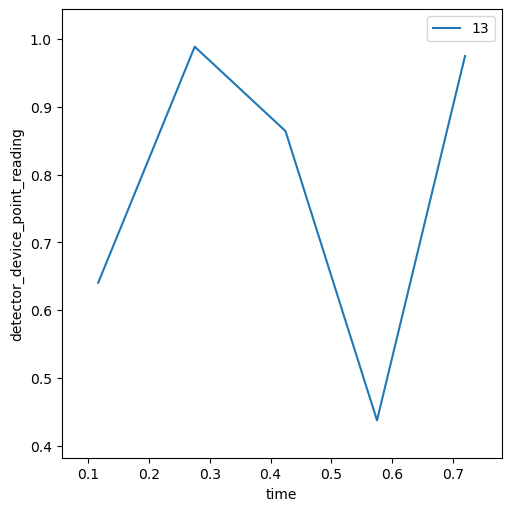

In [61]:
# Try setting the detector's exposure time to 0.1, and then collecting and plotting 5 points.

Note how we have a nice table printed out for us, along with a graph showing the value for each point in the scan. These are created by the `BestEffortCallback` that we have subscribed the `RunEngine` to. Now, let's try adding in a second detector, and seeing what happens.

In [63]:
# Create a second detector object, and set it's exposure time to 0.2 seconds.

Status(obj=Signal(name='detector_device_02_exposure_time', parent='detector_device_02', value=0.2, timestamp=1746735928.265221), done=False, success=False)



Transient Scan ID: 19     Time: 2025-05-08 16:25:43
Persistent Unique Scan ID: '17a69794-341b-4a47-9cbf-0e3f6bef3958'
New stream: 'primary'
+-----------+------------+-------------------------------+----------------------------------+
|   seq_num |       time | detector_device_point_reading | detector_device_02_point_reading |
+-----------+------------+-------------------------------+----------------------------------+
|         1 | 16:25:43.4 |                         0.931 |                            1.493 |
|         2 | 16:25:43.8 |                         0.142 |                            1.165 |
|         3 | 16:25:44.2 |                         0.705 |                            1.370 |
|         4 | 16:25:44.6 |                         0.126 |                            1.819 |
|         5 | 16:25:45.0 |                         0.692 |                            0.121 |
+-----------+------------+-------------------------------+----------------------------------+
generator co

('17a69794-341b-4a47-9cbf-0e3f6bef3958',)

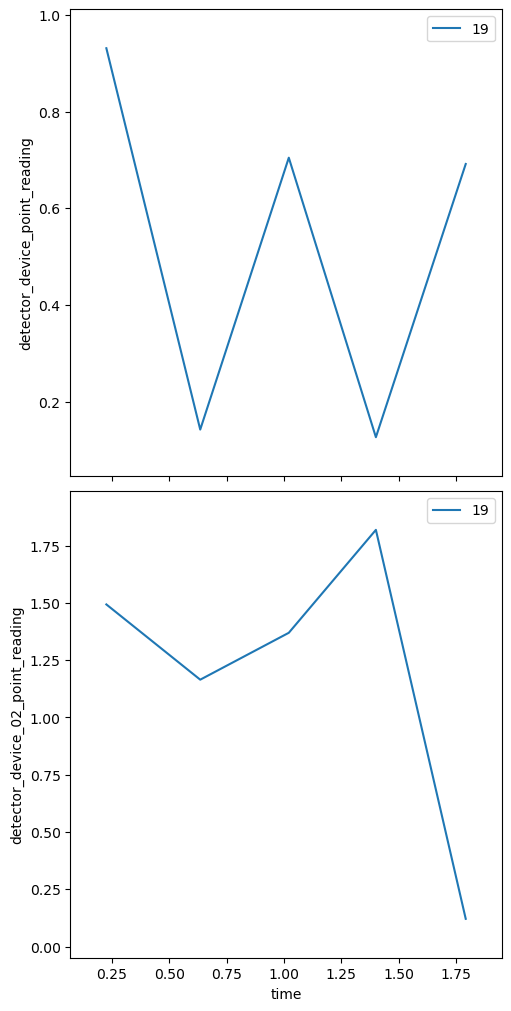

In [69]:
# Collect 5 points with both detector objects.

Notice how it takes roughly two tenths of second between each point. This is because the plan is automatically waiting for all detector trigger statuses to be marked as complete before proceeding to the next reading.

Ok, now let's add in our motion. We can perform a simple single axis step scan with the help of the bluesky `scan` plan.



Transient Scan ID: 5     Time: 2025-05-08 16:34:45
Persistent Unique Scan ID: '38a11a95-1e8f-47e0-af58-e85ee4a32de9'
New stream: 'primary'
+-----------+------------+-------------------------+-------------------------------+----------------------------------+
|   seq_num |       time | movable_device_readback | detector_device_point_reading | detector_device_02_point_reading |
+-----------+------------+-------------------------+-------------------------------+----------------------------------+
|         1 | 16:34:47.0 |                       1 |                         0.393 |                            1.711 |
|         2 | 16:34:47.5 |                       2 |                         0.735 |                            0.804 |
|         3 | 16:34:48.0 |                       3 |                         0.659 |                            1.457 |
|         4 | 16:34:48.5 |                       4 |                         0.595 |                            0.439 |
|         5 | 16:34

('38a11a95-1e8f-47e0-af58-e85ee4a32de9',)

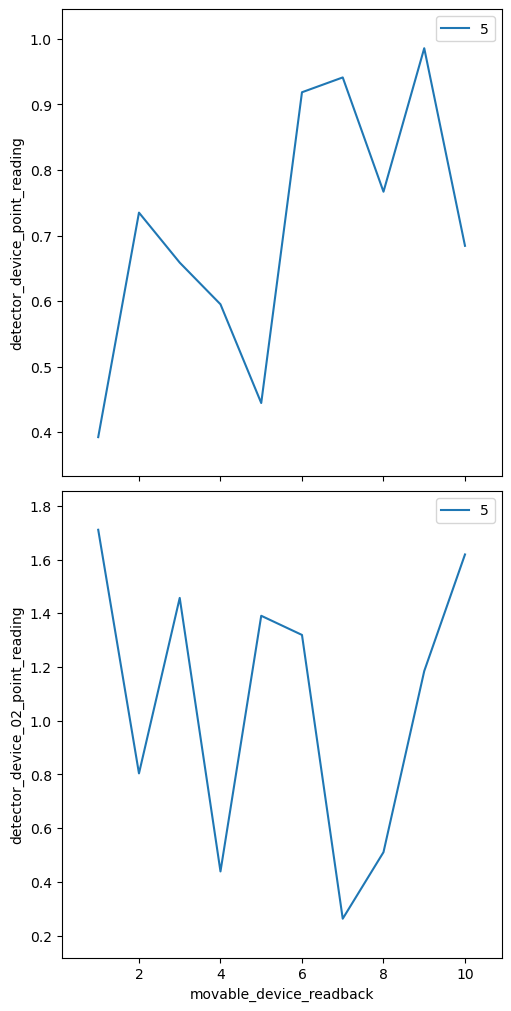

In [95]:
# Using your two detector objects, and your movable, run a single axis step scan from 1 to 10, collecting 10 readings from each detector.

Ok, let's add in a second movable, and try a grid scan.

In [97]:
# Create a second movable device

()



Transient Scan ID: 6     Time: 2025-05-08 16:35:03
Persistent Unique Scan ID: '2c8dbbaa-afe8-478e-a727-2b06437233d4'
New stream: 'primary'
+-----------+------------+-------------------------+----------------------------+-------------------------------+----------------------------------+
|   seq_num |       time | movable_device_readback | movable_device_02_readback | detector_device_point_reading | detector_device_02_point_reading |
+-----------+------------+-------------------------+----------------------------+-------------------------------+----------------------------------+
|         1 | 16:35:05.3 |                       0 |                          0 |                         0.571 |                            1.679 |
|         2 | 16:35:06.0 |                       0 |                          1 |                         0.750 |                            1.106 |
|         3 | 16:35:06.7 |                       0 |                          2 |                         0.308 | 

('2c8dbbaa-afe8-478e-a727-2b06437233d4',)

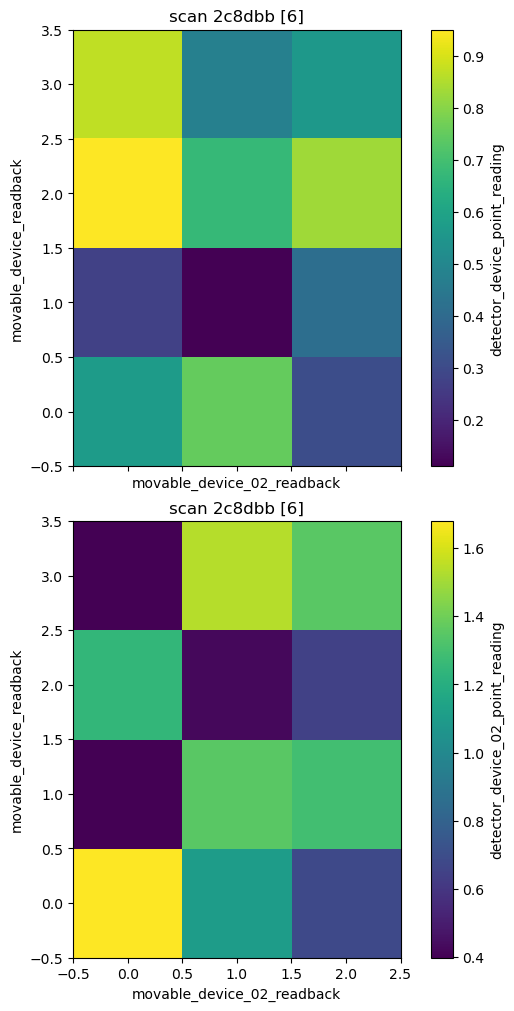

In [98]:
# Collect a grid scan, with both detectors, using your two motors. For the first motor, go from 0 to 3, with  4 points, for the second, 0 to 2 with three points.

Notice how the best effort callback was able to interpret that we performed a 2D scan, and plotted our point detector data accordingly. Also, going back to the reasoning behind these high level protocols/verbs in ophyd - the `grid_scan` plan takes any `Triggerable/Readable` devices in the list of detectors, and any `Movable` devices as arguments for the inner and outer axes. If you implement a temperature controller as a `Movable` ophyd device for example, you can do a grid scan where your outer axis is the temperature, and your inner axis is a physical motor. In this example, you could ramp temperature by increments of 5 degrees, and perform a single axis step scan at each temperature value.

One other thing to note with the grid scan is you are not limited to two axes. I could add any number of movables, and the plan will navigate to all the permutations associated with these.

Ok, now how about if I have a compound device. For example, I have a multi-axis stage, and I want to be able to give it a single value and have all the axes move at once. I can do this by making a higher level `Movable` `Device`, with `MovableDevice` components.

In [ ]:
# Create a simple compound device that has two components of our simple movable device, and when set,
# automatically sets the position of the two sub components to have the angle created by them be equal to the target position.

In [ ]:
two_jack_stage.read()

Notice how this compound device's `read` (and `describe`) will include `hinted` signals from it's sub-components - in this case the `readback` signal from our two `MovableDevice` components.

Also, notice how I didn't add the `read` method (or the `Readable` protocol even!), and yet I can still call it. This is because the `Device` class we are inheriting from implements this method for us already, among others. Also, the `bluesky` protocols, have a feature that makes them `runtime_checkable`, meaning that even for objects that didn't explicitly inherit from them, you can call `isinstance(obj, Readable)` for example. Thus, adding the protocols to your class definition is not strictly necessary in most cases - however, in my opinion it is well worth doing - it will quickly catch issues where there is a missing method for your class.

Let's run a scan with one of our detectors, and our compound device, and see what happens.



Transient Scan ID: 12     Time: 2025-05-08 17:08:47
Persistent Unique Scan ID: '69b7ac93-fde6-4c61-9b4f-1fca70167256'
New stream: 'primary'
+-----------+------------+----------------------------------+------------------------------------+----------------------+-------------------------------+
|   seq_num |       time | two_jack_stage_upstream_readback | two_jack_stage_downstream_readback | two_jack_stage_pitch | detector_device_point_reading |
+-----------+------------+----------------------------------+------------------------------------+----------------------+-------------------------------+
|         1 | 17:08:47.7 |                            0.000 |                              0.000 |                0.000 |                         0.720 |
|         2 | 17:08:47.9 |                            0.000 |                              1.000 |               10.000 |                         0.781 |
|         3 | 17:08:48.2 |                           -1.000 |                           

('69b7ac93-fde6-4c61-9b4f-1fca70167256',)

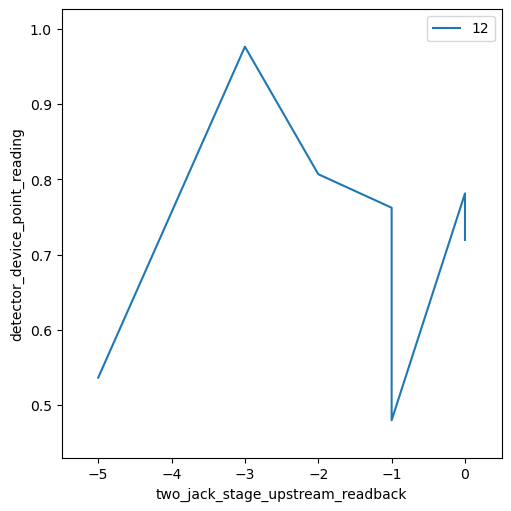

In [112]:
# Perform a single axis step scan with one of our detectors, but using our compound movable. Move it from 0 to 60 degrees, with 7 steps.

Again, notice how our compound device's components have their `hinted` signals propagate to our visualization courtesy of our `BestEffortCallback`. Also, note that our simple simulation movable can only be set to integer values, so our angle positions are approximations. Of course, with real motors you would have higher precision.